# Multimodal search using Amazon Bedrock and Amazon Titan Multimodal Embeddings

## Getting started
In this notebook we focus on introducing you with multimodal search over digital assets, including media and entertainment, using Amazon Titan Multimodal Embeddings.

We will explore how to get embeddings for images, text or both and how to store these in a vector database and perform search queries using vectors.

### Dataset

The "base-frames" folder contain 1000 frames from the movie <a href="https://www.imdb.com/title/tt0087332/">Ghostbusters</a>. Ghostbusters is a 1984 comedy about three eccentric scientists who start a ghost-catching business in New York City. As paranormal activity increases, they become unlikely heroes. Using their wit and homemade technology, they face skepticism and supernatural threats, ultimately battling an ancient god to save the city from destruction.

The "test-frames" folder contain 4 sample frames from the movie <a href="https://www.imdb.com/title/tt0107048/?ref_=nv_sr_srsg_0_tt_8_nm_0_in_0_q_groundhog%2520day">Groundhog Day</a>. Groundhog Day is a comedy starring Bill Murray as Phil Connors, a cynical TV weatherman who finds himself reliving February 2nd repeatedly in Punxsutawney, Pennsylvania. Initially exploiting the situation, Phil eventually uses the time loop to improve himself and win the heart of his producer, Rita. The film explores themes of personal growth and redemption.

### Import needed libraries

In [126]:
!pip install langchain -qU
!pip install faiss-cpu -qU
!pip install -U langchain-community

In [127]:
import os
import json
import boto3
import base64
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from langchain.vectorstores import FAISS
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

### Amazon Bedrock Titan Multimodal Embeddings
In this section of the notebook we create the functions needed to retrieve embeddings using Amazon Bedrock Titan Multimodal Embeddings. 

#### Define output embedding length
Titan Multimodal Embeddings gives you the option to create embeddings with three vector sizes: 1024, 384 or 256

In [128]:
outputEmbeddingLength = 1024 

#### Text embeddings
This function transforms an text into an embeddings vector. 

In [129]:
def get_embeddings_of_text(text, outputEmbeddingLength = outputEmbeddingLength):
    body = json.dumps(
        {
            "inputText": text,
            "embeddingConfig": {
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )
    response = bedrock_runtime.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )
    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

#### Image embeddings
This function transforms an image into an embeddings vector. 

In [130]:
def get_embeddings_of_image(image, outputEmbeddingLength = outputEmbeddingLength):
    with open(image, "rb") as image_file:
        imageEncoded = base64.b64encode(image_file.read()).decode('utf8')

    body = json.dumps(
        {
            "inputImage": imageEncoded,
            "embeddingConfig": { 
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )

    response = bedrock_runtime.invoke_model(
        body=body, 
        modelId="amazon.titan-embed-image-v1", 
        accept="application/json", 
        contentType="application/json"       
    )
    
    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

#### Image + Text embeddings
This function transforms an image + text into an embeddings vector. 

In [131]:
def get_embeddings_of_image_and_text(image, text, outputEmbeddingLength = outputEmbeddingLength):
    with open(image, "rb") as image_file:
        imageEncoded = base64.b64encode(image_file.read()).decode('utf8')

    body = json.dumps(
        {
            "inputImage": imageEncoded,
            "inputText": text,
            "embeddingConfig": {
                "outputEmbeddingLength": outputEmbeddingLength
            }
        }
    )

    response = bedrock_runtime.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )

    vector = json.loads(response['body'].read().decode('utf8'))
    return vector

### Store embeddings in a vector database
After the embeddings for our content have been created, we need to store them in a vector database. In this case we are going to use FAISS for demonstration purposes. <a href="https://github.com/facebookresearch/faiss">FAISS</a> is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM.

#### Create and store images into the vector database

Create embeddings for all the frames in the "base-frames" folder. 

In [132]:
images_folder = "base-frames"
images_items = []

for file in os.listdir(images_folder):
    if file.endswith(".png") or file.endswith(".jpg"):
        file_path = os.path.join(images_folder, file)
        vector = get_embeddings_of_image(file_path)
        images_items.append((file, vector["embedding"]))

Populate the vector database with the images items.

In [133]:
metadata = [{"image_name": item[0]} for item in images_items]
embeddings = [("", item[1]) for item in images_items]
index = FAISS.from_embeddings(
        text_embeddings=embeddings,
        embedding=None,
        metadatas=metadata
    )

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


### Query the database

In the data ingestion phase, we have populated the vector database with the embeddings of our assets. Now at the query phase, we need to transform the query (text input, image input, or both) into a vector and perform search using the enbeddings vector. The embeddings model used at the data ingestion phase needs to be the same embeddings model to be used later at the query phase.

#### Display results
With this function we display the results we retrieve from querying the database.

In [134]:
def display_images_faiss_results(image_data):
    # Create a subplot with 1 row and the number of images as columns
    num_images = len(image_data)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 6)) # returns top 6 images from the vector database which needs to match with the k parameter from the similarity_search_with_score_by_vector below

    # Iterate over each image data entry and display the image and description
    for i, entry in enumerate(image_data):
        image_name = entry[0].metadata['image_name']
        score = entry[1]
        
        # Load and display the image
        img = mpimg.imread(f'{images_folder}/{image_name}')
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].text(0.5, -0.1, image_name, ha='center', transform=axes[i].transAxes)

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

#### Text query
This function transforms text query into an embeddings vector, which we then use to query the vector database. 

In [135]:
def query_the_database_with_text(text):
    vector = get_embeddings_of_text(text)["embedding"]
    results = index.similarity_search_with_score_by_vector(embedding=vector, k=6) # returns top 6 images from the vector database
    return results

In [164]:
text_prompt = "city skyline during the day"

[(Document(metadata={'image_name': 'frame_0659.jpg'}, page_content=''), 1.1994685), (Document(metadata={'image_name': 'frame_0657.jpg'}, page_content=''), 1.2034128), (Document(metadata={'image_name': 'frame_0658.jpg'}, page_content=''), 1.2060728), (Document(metadata={'image_name': 'frame_0160.jpg'}, page_content=''), 1.2070572), (Document(metadata={'image_name': 'frame_0752.jpg'}, page_content=''), 1.2661655), (Document(metadata={'image_name': 'frame_0903.jpg'}, page_content=''), 1.2742455)]


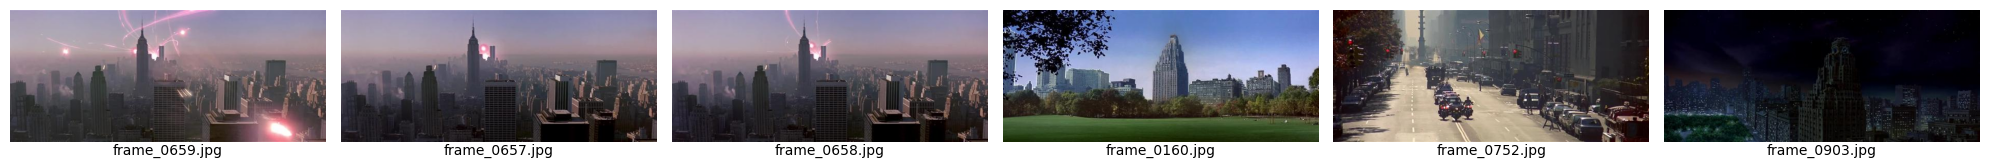

In [165]:
results = query_the_database_with_text(text_prompt)
print(results)
display_images_faiss_results(results)

#### Image query
This function transforms our image query into an embeddings vector, which we then use to query the vector database. We use images from the "test-frames" folder (which contain frames from the Groundhog Day movie) to look for similar images in the "base-frame" folders (which contain frames from the Ghostbusters movie).

In [138]:
def query_the_database_with_image(image):
    vector = get_embeddings_of_image(image)["embedding"]
    results = index.similarity_search_with_score_by_vector(embedding=vector, k=6) # returns top 6 images from the vector database
    return results

In [156]:
test_image_folder = "test-frames"

In [157]:
test_image_name = "groundhogday-1.png"

[(Document(metadata={'image_name': 'frame_0269.jpg'}, page_content=''), 0.74971795), (Document(metadata={'image_name': 'frame_0271.jpg'}, page_content=''), 0.80982363), (Document(metadata={'image_name': 'frame_0277.jpg'}, page_content=''), 0.84618294), (Document(metadata={'image_name': 'frame_0270.jpg'}, page_content=''), 0.84735876), (Document(metadata={'image_name': 'frame_0050.jpg'}, page_content=''), 0.8786926), (Document(metadata={'image_name': 'frame_0051.jpg'}, page_content=''), 0.9013759)]


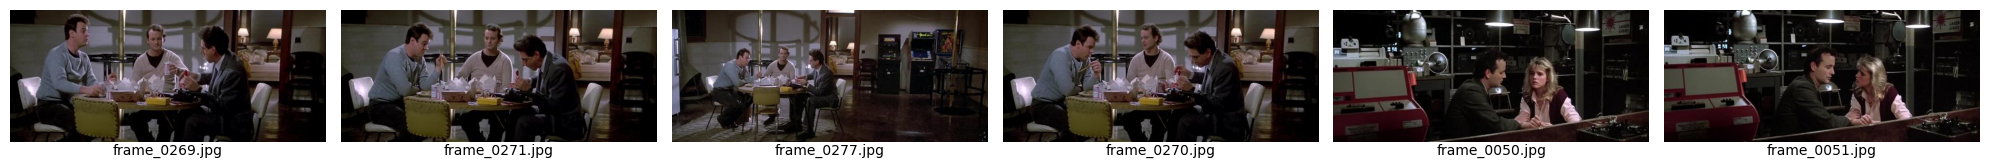

In [158]:
results = query_the_database_with_image(test_image_folder + '/' + test_image_name)
print(results)
display_images_faiss_results(results)